## Fit PDF


In [1]:
# load csv
import pandas as pd

df = pd.read_csv('../customer_support_tickets.csv')

In [2]:
# drop first response time Null/Nan and Time to resolution NaN/Null
df.dropna(inplace=True)

df['First Response Time'] = df['First Response Time'].apply(lambda x: x.replace(' ', 'T').strip())
df['Time to Resolution'] = df['Time to Resolution'].apply(lambda x: x.replace(' ', 'T').strip())


In [3]:
# convert to datetime
df['First Response Time'] = pd.to_datetime(df['First Response Time'])
df['Time to Resolution'] = pd.to_datetime(df['Time to Resolution'])

In [4]:
# remove where 'First Response Time' is greater or equal than 'Time to Resolution'
df = df[df['First Response Time'] < df['Time to Resolution']]

In [5]:
df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0
19,20,Jeffrey Robertson,jameslopez@example.com,39,Female,Canon EOS,2021-03-08,Refund request,Software bug,I'm having an issue with the {product_purchase...,Closed,Wish mouth build resource though.,Low,Chat,2023-06-01 00:46:04,2023-06-01 20:29:04,5.0
28,29,Christine Wang,garciastacy@example.com,30,Other,Fitbit Charge,2020-06-10,Technical issue,Product recommendation,I'm having an issue with the {product_purchase...,Closed,Soldier we such inside.,Critical,Phone,2023-05-31 23:17:17,2023-06-01 06:03:17,5.0
29,30,Austin George,shericase@example.net,67,Male,Xbox,2020-12-26,Cancellation request,Cancellation request,I'm having an issue with the {product_purchase...,Closed,Firm sort voice above which site arrive.,Medium,Phone,2023-06-01 00:54:17,2023-06-01 18:23:17,1.0


In [6]:
data = pd.DataFrame()
data['First Response Time'] = df['First Response Time']
# we only care about the minutes
data['ia_minutes'] = data['First Response Time'].apply(lambda x: x.hour * 60 + x.minute)
data.head()

,First Response Time,ia_minutes
2,2023-06-01 11:14:38,674
4,2023-06-01 00:12:42,12
19,2023-06-01 00:46:04,46
28,2023-05-31 23:17:17,1397
29,2023-06-01 00:54:17,54


In [7]:
data['ia_minutes'].describe()

count    1402.000000
mean      534.676890
std       388.557892
min         1.000000
25%       210.250000
50%       452.000000
75%       804.750000
max      1439.000000
Name: ia_minutes, dtype: float64

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gausshyper,0.000005,1491.361519,1522.835450,0.069552,0.043647,0.009287
triang,0.000005,1490.957779,1506.694745,0.072054,0.031021,0.131815
beta,0.000005,1492.528642,1513.511262,0.072941,0.030691,0.139604
halfnorm,0.000005,1505.828735,1516.320045,0.068359,0.029362,0.174707
skewnorm,0.000005,1507.566592,1523.303558,0.068394,0.029270,0.177383


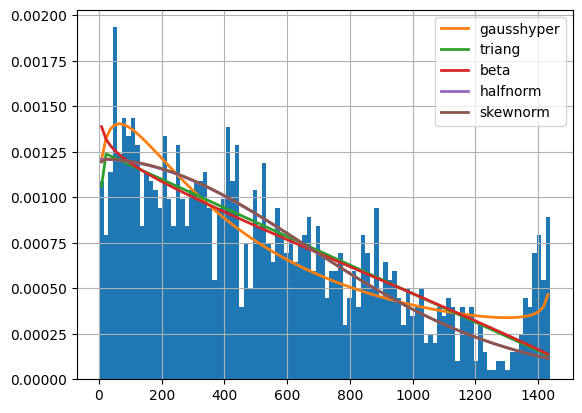

In [8]:
from fitter import Fitter

f = Fitter(data['ia_minutes'])
f.fit()
# may take some time since by default, all distributions are tried,
# but you call manually provide a smaller set of distributions
f.summary()

In [9]:
best_params_arrivals = f.get_best(method='sumsquare_error')
print(best_params_arrivals)

{'gausshyper': {'a': 1.2103881166106585, 'b': 0.843108106913649, 'c': 2.8473099969885896, 'z': 1.6695248905601998, 'loc': -7.421020039786053, 'scale': 1446.4210200397865}}


In [10]:
from scipy import stats

ia = stats.gausshyper.rvs(**best_params_arrivals.get('gausshyper'), size=4_000)

gen = pd.DataFrame()
gen['ia'] = ia

In [11]:
gen.head()

,ia
0,65.512524
1,685.374648
2,1077.207953
3,1242.271678
4,46.798366


In [12]:
gen['ia'].describe()

count    4000.000000
mean      516.098323
std       401.172157
min        -6.821943
25%       172.277746
50%       417.464387
75%       790.698195
max      1438.781281
Name: ia, dtype: float64

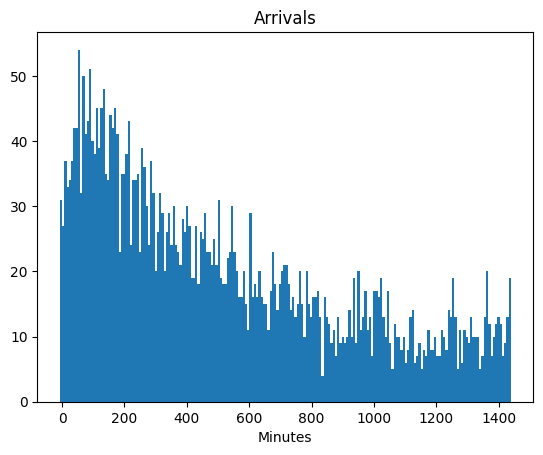

In [13]:
import matplotlib.pyplot as plt

plt.title('Arrivals')
plt.xlabel('Minutes')
plt.hist(gen['ia'], bins=200)
plt.show()

In [14]:
# same for resolution time
data = pd.DataFrame()
data['Time to Resolution'] = df['Time to Resolution']
data['ta_minutes'] = df['Time to Resolution'].apply(lambda x: x.hour * 60 + x.minute)
data

,Time to Resolution,ta_minutes
2,2023-06-01 18:05:38,1085
4,2023-06-01 19:53:42,1193
19,2023-06-01 20:29:04,1229
28,2023-06-01 06:03:17,363
29,2023-06-01 18:23:17,1103
...,...,...
8430,2023-06-01 17:16:36,1036
8432,2023-06-01 15:47:38,947
8435,2023-06-02 00:16:42,16
8448,2023-06-01 19:14:59,1154


In [15]:
data['ta_minutes'].head()

2     1085
4     1193
19    1229
28     363
29    1103
Name: ta_minutes, dtype: int64

In [16]:
data['ta_minutes'].describe()

count    1402.000000
mean      890.372325
std       348.097412
min         1.000000
25%       637.250000
50%       948.000000
75%      1175.750000
max      1439.000000
Name: ta_minutes, dtype: float64

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gausshyper,0.000004,1497.964293,1529.438223,0.039057,0.019903,0.627777
argus,0.000004,1495.514675,1511.251640,0.041707,0.013725,0.951033
beta,0.000004,1496.371739,1517.354360,0.042441,0.019441,0.656963
johnsonsb,0.000004,1495.055903,1516.038524,0.044257,0.021289,0.541657
triang,0.000004,1497.109963,1512.846928,0.045275,0.024429,0.366862


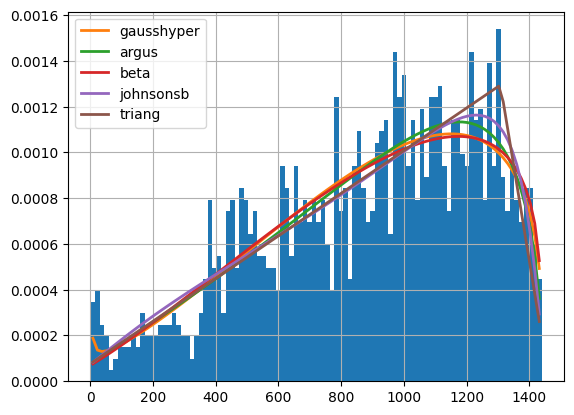

In [17]:
f = Fitter(data['ta_minutes'])
f.fit()
f.summary()

In [22]:
# The best fit is the gausshyper distribution, but we can also try the argus distribution
argus_params = f.fitted_param['argus']
print(argus_params)

(1.2968719888041922, -82.73543787957408, 1524.8395788940456)


In [23]:
ta = stats.argus.rvs(*argus_params, size=4_000)
gen['ta'] = ta

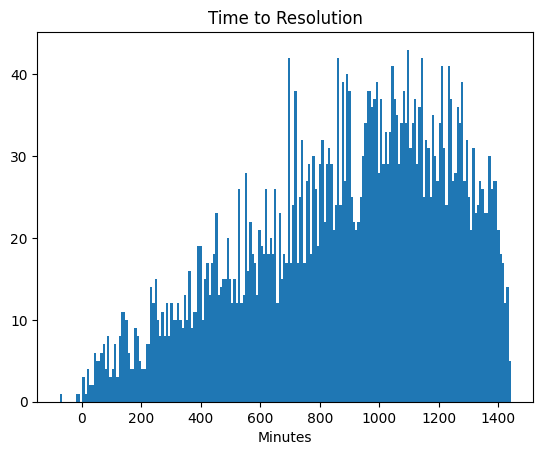

In [24]:
plt.title('Time to Resolution')
plt.xlabel('Minutes')
plt.hist(gen['ta'], bins=200)
plt.show()